In [7]:
import cv2, os, re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import decimal
import shutil
import albumentations as A
import segmentation_models as sm
import keras.backend as K
sm.set_framework('tf.keras')
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import rotate
from deskew import determine_skew
#import torch, torchvision

sm.framework()
%matplotlib inline

#!pip install deskew

Segmentation Models: using `keras` framework.


In [8]:
BASE_DIR = ''
IMG_DIR = BASE_DIR + "images/"
MASK_DIR = BASE_DIR + "masks/"
COLL_DIR = BASE_DIR + "collage/"
OCR_CROP = BASE_DIR + "ocr_crop/"
ROTATED_DIR = BASE_DIR + "rotated_imgs/"

data = pd.read_csv('data.csv')

In [164]:
imgs = os.listdir(IMG_DIR)
masks = os.listdir(MASK_DIR)

print(f"Img files: {len(imgs)}. ---> {imgs[:3]}")
print(f"Mask files :  {len(masks)}. ---> {masks[:3]}")
print(f'Length of dataset: {len(data)}')

Img files: 1244. ---> ['id_1000_value_176_881.jpg', 'id_1001_value_1113_124.jpg', 'id_1002_value_105_174.jpg']
Mask files :  1244. ---> ['id_1000_value_176_881.jpg', 'id_1001_value_1113_124.jpg', 'id_1002_value_105_174.jpg']
Length of dataset: 1244


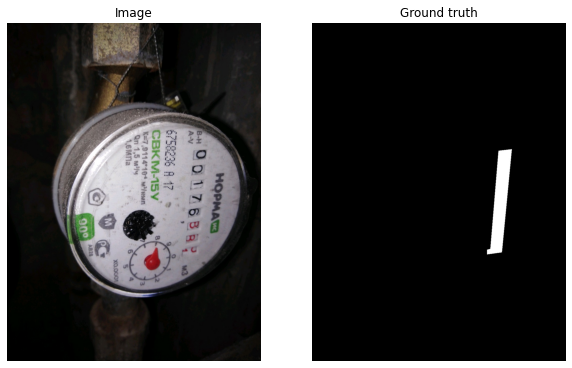

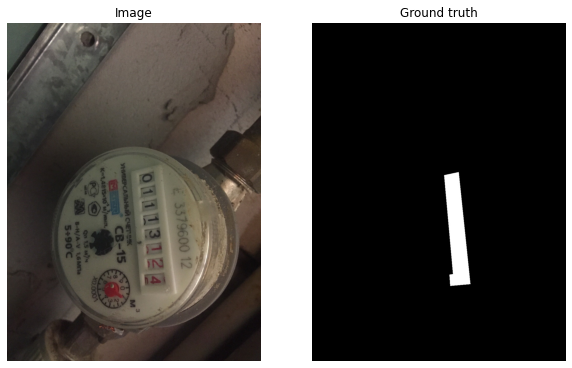

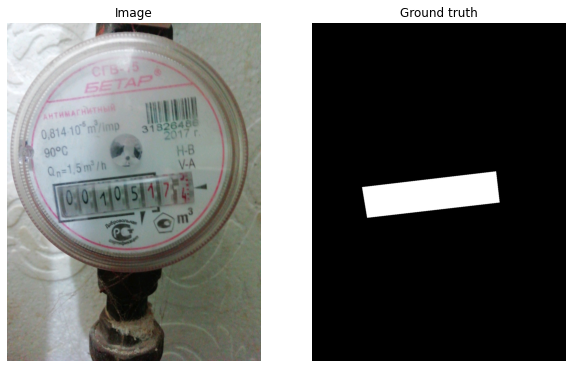

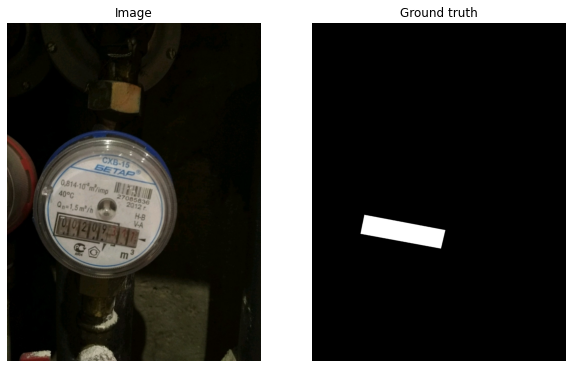

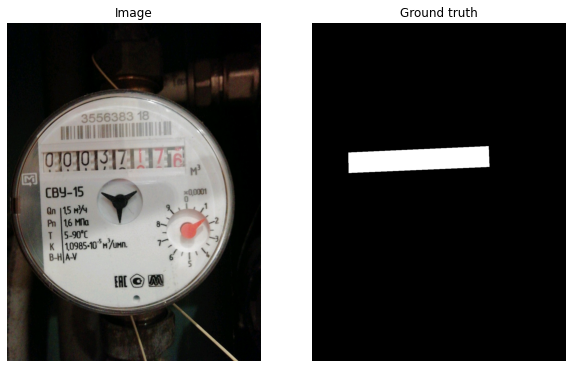

In [57]:
rows = 1
columns = 2

for img, mask in zip(imgs[:5], masks[:5]):
    img_path = os.path.join(IMG_DIR, img)
    mask_path = os.path.join(MASK_DIR, mask)
    
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(rows, columns, 1)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) 
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")
    
    fig.add_subplot(rows, columns, 2)
    mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)
    plt.imshow(mask, interpolation=None)
    plt.axis('off')
    plt.title("Ground truth")

In [9]:
data.head()

,photo_name,value,location
0,id_53_value_595_825.jpg,595.825,"{'type': 'polygon', 'data': [{'x': 0.30788, 'y..."
1,id_553_value_65_475.jpg,65.475,"{'type': 'polygon', 'data': [{'x': 0.26133, 'y..."
2,id_407_value_21_86.jpg,21.860,"{'type': 'polygon', 'data': [{'x': 0.27545, 'y..."
3,id_252_value_313_322.jpg,313.322,"{'type': 'polygon', 'data': [{'x': 0.21967, 'y..."
4,id_851_value_305_162.jpg,305.162,"{'type': 'polygon', 'data': [{'x': 0.06983, 'y..."


In [10]:
def location_vals(obvs, x_or_y):
    '''
    Function uses regular expressions to parse the "location" string for each observation.
    Inputs are "obvs" and "x_or_y".
    
    obvs: This simply serves as the string being passed into the function.
    x_or_y: If "x" is entered, then the function extracts all "x" location values. If anything else, then it extracts "y" location values.
    '''
    if x_or_y == 'x':
        x = re.findall(r"\'x\': ([0-9.]*),", obvs)
        return x
    else:
        y = re.findall(r"\'y\': ([0-9.]*)}", obvs)
        return y

In [11]:
data['x_loc_perc'] = data['location'].apply(lambda obvs: location_vals(obvs, 'x'))
data['y_loc_perc'] = data['location'].apply(lambda obvs: location_vals(obvs, 'y'))
display(data.head())

,photo_name,value,location,x_loc_perc,y_loc_perc
0,id_53_value_595_825.jpg,595.825,"{'type': 'polygon', 'data': [{'x': 0.30788, 'y...","[0.30788, 0.30676, 0.53501, 0.53445, 0.56529, ...","[0.30207, 0.32731, 0.33068, 0.33699, 0.33741, ..."
1,id_553_value_65_475.jpg,65.475,"{'type': 'polygon', 'data': [{'x': 0.26133, 'y...","[0.26133, 0.31405, 0.31741, 0.30676, 0.33985, ...","[0.24071, 0.23473, 0.26688, 0.26763, 0.60851, ..."
2,id_407_value_21_86.jpg,21.860,"{'type': 'polygon', 'data': [{'x': 0.27545, 'y...","[0.27545, 0.37483, 0.38935, 0.28185]","[0.19134, 0.18282, 0.76071, 0.76613]"
3,id_252_value_313_322.jpg,313.322,"{'type': 'polygon', 'data': [{'x': 0.21967, 'y...","[0.21967, 0.70811, 0.70008, 0.21699]","[0.50845, 0.53256, 0.61295, 0.58883]"
4,id_851_value_305_162.jpg,305.162,"{'type': 'polygon', 'data': [{'x': 0.06983, 'y...","[0.06983, 0.34763, 0.34663, 0.36622, 0.37125, ...","[0.43491, 0.42285, 0.41795, 0.41607, 0.4628, 0..."


In [12]:
def image_size(img_name):
    image_path = os.path.join(IMG_DIR, img_name)
    img = cv2.imread(image_path)
    return img.shape

#Apply function to each row of DataFrame.
data['shape'] = data['photo_name'].apply(image_size)
display(data.head())

,photo_name,value,location,x_loc_perc,y_loc_perc,shape
0,id_53_value_595_825.jpg,595.825,"{'type': 'polygon', 'data': [{'x': 0.30788, 'y...","[0.30788, 0.30676, 0.53501, 0.53445, 0.56529, ...","[0.30207, 0.32731, 0.33068, 0.33699, 0.33741, ...","(1333, 1000, 3)"
1,id_553_value_65_475.jpg,65.475,"{'type': 'polygon', 'data': [{'x': 0.26133, 'y...","[0.26133, 0.31405, 0.31741, 0.30676, 0.33985, ...","[0.24071, 0.23473, 0.26688, 0.26763, 0.60851, ...","(1000, 1333, 3)"
2,id_407_value_21_86.jpg,21.860,"{'type': 'polygon', 'data': [{'x': 0.27545, 'y...","[0.27545, 0.37483, 0.38935, 0.28185]","[0.19134, 0.18282, 0.76071, 0.76613]","(1000, 1333, 3)"
3,id_252_value_313_322.jpg,313.322,"{'type': 'polygon', 'data': [{'x': 0.21967, 'y...","[0.21967, 0.70811, 0.70008, 0.21699]","[0.50845, 0.53256, 0.61295, 0.58883]","(1333, 1000, 3)"
4,id_851_value_305_162.jpg,305.162,"{'type': 'polygon', 'data': [{'x': 0.06983, 'y...","[0.06983, 0.34763, 0.34663, 0.36622, 0.37125, ...","[0.43491, 0.42285, 0.41795, 0.41607, 0.4628, 0...","(1333, 1000, 3)"


In [13]:
data.to_csv('new_data.csv')

In [62]:
#Save height and weight data as separate features.
data['height'] = data['shape'].apply(lambda x: x[0])
data['width'] = data['shape'].apply(lambda x: x[1])

#Display stats for height and width of images.
data[['height', 'width']].describe()

,height,width
count,1244.000000,1244.000000
mean,1320.112540,1060.707395
std,201.842639,159.417396
min,480.000000,864.000000
25%,1333.000000,1000.000000
50%,1333.000000,1000.000000
75%,1333.000000,1000.000000
max,2168.000000,2058.000000


In [63]:
out_rgb = []
out_mask = []

counter_empty = 0

for p_img, p_mask in zip(imgs, masks):   
    img_path = os.path.join(IMG_DIR, p_img)
    mask_path = os.path.join(MASK_DIR, p_mask)
    
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256)) / 255.
    
    mask = cv2.imread(mask_path)
    mask = cv2.resize(mask, (256, 256))
    mask = 1.0 * (mask[:, :, 0] > .1)    
    if 1 not in mask: counter_empty+=1
    mask = np.expand_dims(mask, axis=-1)

    out_rgb += [img]
    out_mask += [mask]

out_rgb = np.array(out_rgb, dtype = 'float32')
out_mask = np.array(out_mask, dtype = 'float32')

print(f"Mask files: {out_mask.shape[0]}. ---> Empty: {counter_empty}")

Mask files: 1244. ---> Empty: 0


In [64]:
out_rgb.shape, out_mask.shape

((1244, 256, 256, 3), (1244, 256, 256, 1))

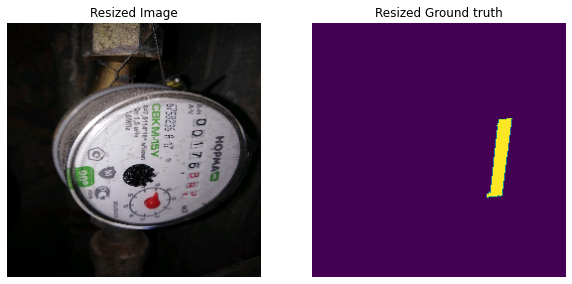

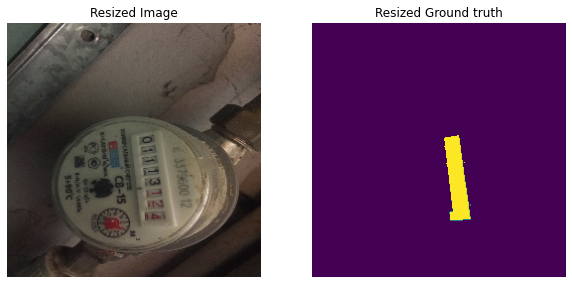

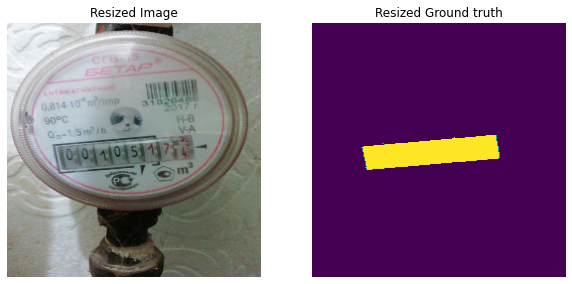

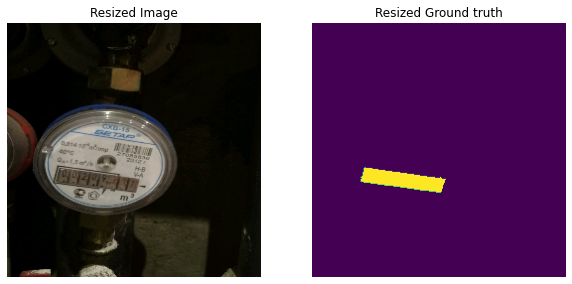

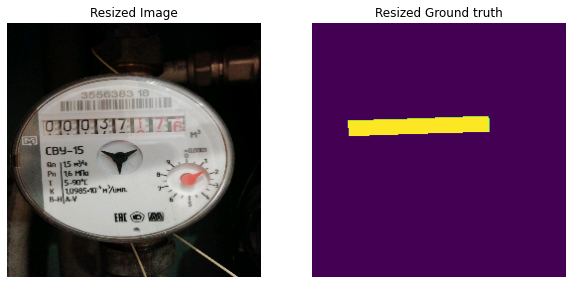

In [65]:
rows = 1
columns = 2

for img, mask in zip(out_rgb[:5], out_mask[:5]):
    #img_path = os.path.join(IMG_DIR, image)
    #mask_path = os.path.join(MASK_DIR, msk)
    
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(rows, columns, 1)
    #img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) 
    plt.imshow(img)
    plt.axis('off')
    plt.title("Resized Image")
    
    fig.add_subplot(rows, columns, 2)
    #mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)
    plt.imshow(mask, interpolation=None)
    plt.axis('off')
    plt.title("Resized Ground truth")

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    out_rgb, 
    out_mask, 
    test_size=0.1, 
    shuffle=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1119, 256, 256, 3),
 (125, 256, 256, 3),
 (1119, 256, 256, 1),
 (125, 256, 256, 1))

In [67]:
aug = A.Compose([
    A.OneOf([
        A.RandomSizedCrop(min_max_height=(50, 101), height=256, width=256, p=0.5),
        A.PadIfNeeded(min_height=256, min_width=256, p=0.5)
    ],p=1),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
    ], p=0.8)])

In [68]:
def make_image_gen(X_train, y_train, aug, batch_size):
    aug_x = []
    aug_y = []
    while True:
        for i in range(X_train.shape[0]): 
            augmented = aug(image=X_train[i], mask=y_train[i])
            x, y = augmented['image'],  augmented['mask']
            aug_x.append(x)
            aug_y.append(y)
            if len(aug_x)>=batch_size:
                yield np.array(aug_x, dtype = 'float32'), np.array(aug_y, dtype = 'float32')
                aug_x, aug_y=[], []

In [69]:
train_gen = make_image_gen(X_train, y_train, aug, 32)
aug_x, aug_y = next(train_gen)
np.shape(aug_x), np.shape(aug_y)

((32, 256, 256, 3), (32, 256, 256, 1))

In [70]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [71]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=15),
    tf.keras.callbacks.ModelCheckpoint(filepath='water_meters.h5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=5, 
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)   
]

In [72]:
def DiceLoss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(K.dot(targets, inputs))
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice


ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

In [74]:
model = sm.Unet('efficientnetb0', classes=1, input_shape=(256, 256, 3), activation='sigmoid', encoder_weights='imagenet')
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=FocalLoss, metrics = [dice_coef] )

In [75]:
model.fit_generator(generator=make_image_gen(X_train, y_train, aug, 16), steps_per_epoch = 200, epochs=50, callbacks = callbacks,validation_data = (X_test, y_test))

C:\Users\Andrey\anaconda3\envs\ev_2\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
200/200 [==============================] - 54s 231ms/step - loss: 0.0324 - dice_coef: 0.0954 - val_loss: 0.0101 - val_dice_coef: 0.1100

Epoch 00001: val_loss improved from inf to 0.01014, saving model to water_meters.h5


C:\Users\Andrey\anaconda3\envs\ev_2\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
200/200 [==============================] - 42s 211ms/step - loss: 0.0116 - dice_coef: 0.1555 - val_loss: 0.0081 - val_dice_coef: 0.1817

Epoch 00002: val_loss improved from 0.01014 to 0.00812, saving model to water_meters.h5
Epoch 3/50
200/200 [==============================] - 42s 210ms/step - loss: 0.0102 - dice_coef: 0.1867 - val_loss: 0.0029 - val_dice_coef: 0.2949

Epoch 00003: val_loss improved from 0.00812 to 0.00286, saving model to water_meters.h5
Epoch 4/50
200/200 [==============================] - 42s 211ms/step - loss: 0.0077 - dice_coef: 0.2222 - val_loss: 0.0028 - val_dice_coef: 0.3315

Epoch 00004: val_loss improved from 0.00286 to 0.00284, saving model to water_meters.h5
Epoch 5/50
200/200 [==============================] - 42s 211ms/step - loss: 0.0081 - dice_coef: 0.2231 - val_loss: 0.0024 - val_dice_coef: 0.3118

Epoch 00005: val_loss improved from 0.00284 to 0.00242, saving model to water_meters.h5
Epoch 6/50
200/200 [==============================] - 42

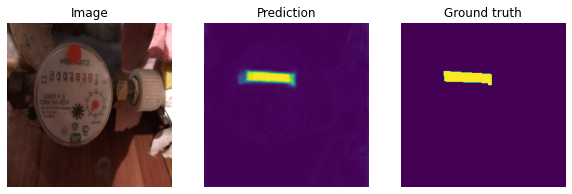

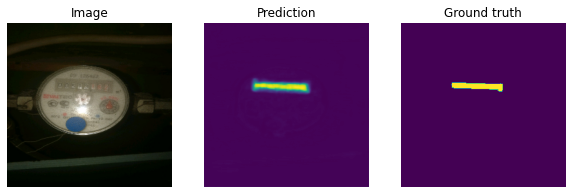

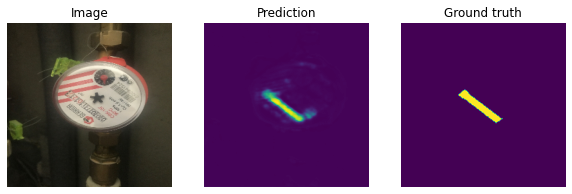

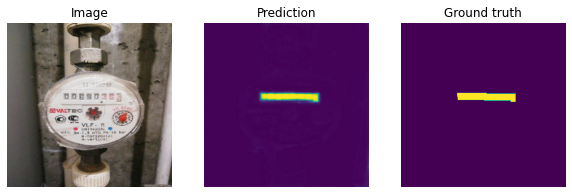

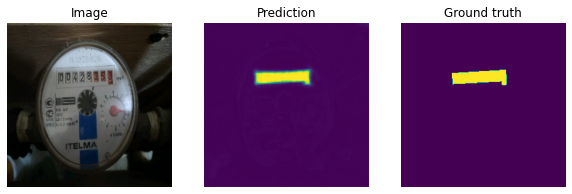

In [76]:
preds = model.predict(X_test)

rows = 1
columns = 3

for img, pred, mask in zip(X_test[:5], preds[:5], y_test[:5]):
    
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")
    
    fig.add_subplot(rows, columns, 2)
    plt.imshow(pred, interpolation=None)
    plt.axis('off')
    plt.title("Prediction")
    
    fig.add_subplot(rows, columns, 3)
    plt.imshow(mask, interpolation=None)
    plt.axis('off')
    plt.title("Ground truth")

In [77]:
#Create function to crop images.
def crop(img, bg, mask) -> np.array:
    '''
    Function takes image, background, and mask, and crops the image.
    The cropped image should correspond only with the positive portion of the mask.
    '''
    fg = cv2.bitwise_or(img, img, mask=mask) 
    fg_back_inv = cv2.bitwise_or(bg, bg, mask=cv2.bitwise_not(mask))
    New_image = cv2.bitwise_or(fg, fg_back_inv)
    return New_image

In [80]:
ocr_path = 'ocr_crop'

for n, image, mask in zip(range(len(os.listdir(IMG_DIR))), os.listdir(IMG_DIR), os.listdir(MASK_DIR)):
    dir_img = os.path.join(IMG_DIR, image)
    dir_mask = os.path.join(MASK_DIR, mask)
    
    #Read images and masks.
    img = cv2.imread(dir_img).astype('uint8')
    mask = cv2.imread(dir_mask).astype('uint8')
    
    #Get dimensions of image.
    h, w, _ = img.shape
    
    #Ensure mask is binary, and create black background in shape of image.
    mask = cv2.resize(cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY), (w, h)) # Resize image
    bg = np.zeros_like(img, 'uint8') # Black background

    #Crop image based on mask and make it RBG.
    New_image = crop(img,bg,mask)
    New_image = cv2.cvtColor(New_image, cv2.COLOR_BGR2RGB)

    #Extract portion of image where meter reading is.
    #Use min and max x and y coordinates to obtain final image.
    where = np.array(np.where(New_image))
    x1, y1, z1 = np.amin(where, axis=1)
    x2, y2, z2 = np.amax(where, axis=1)
    sub_image = New_image.astype('uint8')[x1:x2, y1:y2]

    #Write image to file
    cv2.imwrite(os.path.join(ocr_path , image), sub_image)

In [ ]:
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import rotate

from deskew import determine_skew


for img in imgs:
    img_path = os.path.join(OCR_CROP, img)
    rotated_img_path = os.path.join(ROTATED_DIR, img)#.split('.jpg')[0]+'.png')
    image = io.imread(img_path)
    grayscale = rgb2gray(image)
    angle = determine_skew(grayscale)
    rotated = rotate(image, angle, resize=True) * 255
    io.imsave(rotated_img_path, rotated.astype(np.uint8))
    
rotated = os.listdir(ROTATED_DIR)
print(f"Rotated files :  {len(rotated)}. ---> {rotated[:3]}")

In [3]:
rotated = os.listdir(ROTATED_DIR)
print(f"Rotated files :  {len(rotated)}. ---> {rotated[:3]}")

Rotated files :  1244. ---> ['id_1000_value_176_881.jpg', 'id_1001_value_1113_124.jpg', 'id_1002_value_105_174.jpg']


In [6]:
def resize_aspect_fit(path, final_size: int, write_to, save=True):
    '''
    Function resizes the image to specified size.
    
    path - The path to the directory with images.
    final_size - The size you want the final images to be. Should be in int (will be used for w and h).
    write_to - The file you wish to write the images to. 
    save - Whether to save the files (True) or return them.
    '''   
    for item in os.listdir(path):
        im = Image.open(path+item)
        f, e = os.path.splitext(path+item)
        size = im.size
        ratio = float(final_size) / max(size)
        new_image_size = tuple([int(x*ratio) for x in size])
        im = im.resize(new_image_size, Image.ANTIALIAS)
        new_im = Image.new("RGB", (final_size, final_size))
        new_im.paste(im, ((final_size-new_image_size[0])//2, (final_size-new_image_size[1])//2))
        if save==True:
            cv2.imwrite(os.path.join(resize_for_rcnn, item), np.array(new_im))
        else:
            return np.array(new_im)

In [7]:
#%%skip True

#Reshape all images to 224x224x3 size, while retaining aspect. 
#IMPORTANT FOR PREPROCESSING IMAGES

from PIL import Image
import os, sys

if os.path.exists('./resized_for_rcnn') == False:
    os.mkdir('resized_for_rcnn')
else:
    pass

#Specify argument values for resize function.
resize_for_rcnn = './resized_for_rcnn'
path = './ocr_crop/'
final_size = 224

resize_aspect_fit(path, final_size, resize_for_rcnn)

C:\Temp\ipykernel_11192\2193967606.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im = im.resize(new_image_size, Image.ANTIALIAS)
